# Pipeline C

In [ ]:
import os
import sys
sys.path.append("../")

import datetime

from datetime import datetime, timedelta, date

from pandas import read_csv, to_datetime, concat, DataFrame
from geopandas import GeoDataFrame, read_file
import pandas as pd
import numpy as np
import movingpandas as mpd
from shapely.geometry import Point

import tsfel
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import gaussian_kde
from scipy.ndimage import zoom

import matplotlib.pyplot as plt

from dtaidistance import dtw_ndim
from dtaidistance import dtw

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import geopandas as gpd
from holoviews.element import tiles, Points
import contextily as ctx

import hvplot
import hvplot.pandas
import holoviews as hv
from holoviews import opts, dim;
import matplotlib.pyplot as plt

opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':'ESRI', 'cmap':'Viridis', 'colorbar':True}

In [ ]:
from src.macros.macros1 import COLUMNS_DTYPES
from src.preprocess.load import MMSIperDayFeatures, TYPES_TO_INT, get_data_for_time_frame, query_by_type
from src.analyse.helper import discretize_equal_size

+ Import the coastal line map and convert to geoDataFrame

In [16]:
file = '../assets/maps/kiel_fjord_epsg4326.geojson'
map_gdf = read_file(file)
map_coastline = map_gdf[map_gdf.name=="kiel fjord coastline"]
map_waterarea = map_gdf[map_gdf.name=="kiel fjord water area"]


In [ ]:
coastline_plt = map_coastline.hvplot(geo=True, line_width=2, line_color='black', alpha=1).opts(bgcolor='rgba(0, 0, 0, 0)')#, xaxis=None, yaxis=None, toolbar=None, show_frame=False)

## 1. LOAD the data

In [ ]:
START_DATE = date(year=2022, month=7, day=5)
END_DATE = date(year=2022, month=7, day=5)

In [ ]:
src = r"../assets/csv/"
data = get_data_for_time_frame(src, START_DATE, END_DATE)

data: list
+ mmsi: int
+ day: datetime.date
+ static: DataFrame
+ own: DataFrame
+ s2s: DataFrame

## 2. select by TYPE

In [ ]:
selected_type = "SAILING_FAMILY"
data_selected = query_by_type(data, selected_type)
print(f"Number of {selected_type} ships found: {len(data_selected)} ships")

## 3. prepare DATA

- Update the trajectory id
- feature set (subset of own/s2s)
- prepare the data

In [9]:
##> Update the traj_id of each of the data.own in the structure of f"{mmsi}.{day}.{traj_id}" <##

#> Loop over the data objects list
for ft in data_selected:
    mmsi = ft.mmsi
    new_col = ft.own["mmsi"].astype(str) + "." + ft.own["traj_id"].astype(str)
    ft.own["traj_id"] = new_col

In [10]:
own_feature_list = [d.own for d in data] # list of df

+ Store in TrajectoryCollection

In [11]:
traj_list = []
for ft in data:
    df = ft.own
    geometry = [Point(xy) for xy in zip(df['inter_lon'], df['inter_lat'])] # ! lon->lat and not lat->lon
    gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    traj_list.append(mpd.Trajectory(gdf, traj_id='traj_id', obj_id='mmsi' ,t='t'))

In [12]:
tc = mpd.TrajectoryCollection(traj_list, traj_id_col='traj_id', t='t', crs='epsg:4326')

In [13]:
##> Check trajectories validity <##

valid_list = []
for traj in tc.trajectories:
    valid_list.append(traj.is_valid())
    # print(traj.crs)
all(valid_list)

True

+ Get the geoFence corner values from map:

In [17]:
_waterarea_polygon = map_waterarea.geometry.values[0]
lon_min, lat_min, lon_max, lat_max = _waterarea_polygon.bounds

+ Discretize the geoarea into grid:

In [21]:
##> Define a function to collect the discritized lat, lon in to the passed dataframe

def add_pixel_bins_column(df, lat_min, lon_min, lat_max, lon_max):

    lat = df.inter_lat
    lon = df.inter_lon

    # geo min- max for lat, lon separately
    # provide num bins (pixels)
    # returns series + new column with 0 <= i <= num bins - 1
    lat_bin = discretize_equal_size(lat, 
                                       lo_range=lat_min, 
                                       hi_range=lat_max, 
                                       num_bins=100)
    
    lon_bin = discretize_equal_size(lon, 
                                       lo_range=lon_min, 
                                       hi_range=lon_max, 
                                       num_bins=100)

    df['lat_bin'] = lat_bin["bin_indices"]
    df['lon_bin'] = lon_bin["bin_indices"]

    return df


In [22]:
grid_df_list = []
for traj in tc.trajectories:
    # traj.df['datetime'] = traj.df.index
    
    grid_df_list.append(add_pixel_bins_column(traj.df,
                                              lat_min=lat_min,
                                              lon_min=lon_min,
                                              lat_max=lat_max,
                                              lon_max=lon_max))

# Concatenate the DataFrames into one DataFrame
concatenated_df = pd.concat([df.reset_index() for df in grid_df_list], ignore_index=True)

# Create a new index in the order of concatenation
concatenated_df.index = range(len(concatenated_df))

# Optionally, set a new index name (e.g., 'new_index')
concatenated_df.index.name = 'new_index'

In [23]:
concatenated_df.columns

Index(['t', 'epoch', 'status', 'heading', 'course', 'speed', 'turn',
       'maneuver', 'roa', 'inter_speed', 'inter_turn', 'traj_id', 'mmsi',
       'calc_speed', 'direction', 'angular_difference', 'calc_acc',
       'inter_lat', 'inter_lon', 'in_waterways', 'distance_shore', 'geometry',
       'lat_bin', 'lon_bin'],
      dtype='object')

+ Declare you metric

In [24]:
stat_feature_method = tsfel.calc_median
stat_feature_method_name = "median"

+ Apply the metric on the targeted columns and save the result in a grid map:

In [25]:
#> Targeted feature columsn for computation:
feature_to_stat = 'calc_speed'

#> Initialize the added feature column
added_feature_col_name = f'{feature_to_stat}:{stat_feature_method_name}'
concatenated_df[added_feature_col_name] = 0
grid_feature = np.zeros((100, 100)) # 100 is the max_lat and max_lon from above

#> Loop over the groups -> calculate the 
for (i,j),group in concatenated_df.groupby(['lat_bin', 'lon_bin']):
    value = stat_feature_method(group[feature_to_stat]);
    # add the calculated feature to the dataframe
    concatenated_df.loc[group.index, added_feature_col_name] = value
    # build up the featuer image
    grid_feature[i,j] = value

/tmp/ipykernel_652303/638329865.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0358343417855903' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  concatenated_df.loc[group.index, added_feature_col_name] = value


+ Store the calculated feature in the trajectoryCollection

In [26]:
##> Add the new clustered column to the trajectories
start_index = 0
for traj in tc.trajectories:
    stop_index = start_index + len(traj.df)
    # print(len(traj.df))
    # print(start_index, stop_index)
    traj.df[added_feature_col_name] = concatenated_df.iloc[start_index:stop_index][added_feature_col_name].values
    start_index = stop_index

In [27]:
tc.trajectories[0].df.tail(3)

,epoch,status,heading,course,speed,turn,maneuver,roa,inter_speed,inter_turn,...,angular_difference,calc_acc,inter_lat,inter_lon,in_waterways,distance_shore,geometry,lat_bin,lon_bin,calc_speed:median
t,,,,,,,,,,,,,,,,,,,,,
2022-07-05 23:11:00,1.657063e+09,0,29.0,30.0,10.898438,0.0,0,0,10.854562,0.0,...,1.572208,740.940035,54.445606,10.246030,1,3.157696,POINT (10.24603 54.44561),93,62,13.191936
2022-07-05 23:11:06,1.657063e+09,0,29.0,30.0,10.796875,0.0,0,1,10.796875,0.0,...,0.157854,287.289523,54.445863,10.246278,1,3.183431,POINT (10.24628 54.44586),93,62,13.191936
2022-07-05 23:11:12,1.657063e+09,0,29.0,30.0,10.796875,0.0,0,0,10.796875,0.0,...,1.824598,-88.943122,54.446109,10.246531,1,3.208175,POINT (10.24653 54.44611),93,62,13.191936


## Heatmap and Contour plot

+ Scale the feature column

In [28]:
scaler = MinMaxScaler()
scaled_feature = scaler.fit_transform(concatenated_df[added_feature_col_name].to_numpy().reshape(-1,1))
scaled_feature_col_name = f'scaled:{added_feature_col_name}'
concatenated_df[scaled_feature_col_name] = scaled_feature

In [29]:
concatenated_df.tail(3)

,t,epoch,status,heading,course,speed,turn,maneuver,roa,inter_speed,...,calc_acc,inter_lat,inter_lon,in_waterways,distance_shore,geometry,lat_bin,lon_bin,calc_speed:median,scaled:calc_speed:median
new_index,,,,,,,,,,,,,,,,,,,,,
33411,2022-07-05 20:42:06,1.657054e+09,15,511.0,266.25,2.0,128.0,0,0,2.494514,...,-154.798230,54.380965,10.169819,0,0.464572,POINT (10.16982 54.38097),48,20,4.560178,0.07929
33412,2022-07-05 20:42:12,1.657054e+09,15,511.0,266.25,2.0,128.0,0,0,2.310428,...,-178.361961,54.380953,10.169711,0,0.453926,POINT (10.16971 54.38095),48,20,4.560178,0.07929
33413,2022-07-05 20:42:18,1.657054e+09,15,511.0,266.25,2.0,128.0,0,0,2.124727,...,-196.900674,54.380943,10.169612,0,0.444229,POINT (10.16961 54.38094),48,20,4.560178,0.07929


+ Store the calculated feature in the trajectoryCollection

In [30]:
##> Add the new clustered column to the trajectories
start_index = 0
for traj in tc.trajectories:
    stop_index = start_index + len(traj.df)
    # print(len(traj.df))
    # print(start_index, stop_index)
    traj.df[scaled_feature_col_name] = concatenated_df.iloc[start_index:stop_index][added_feature_col_name].values
    start_index = stop_index

+ Create a heatmap

/home/gfalouji/miniconda3/envs/captnAIS/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


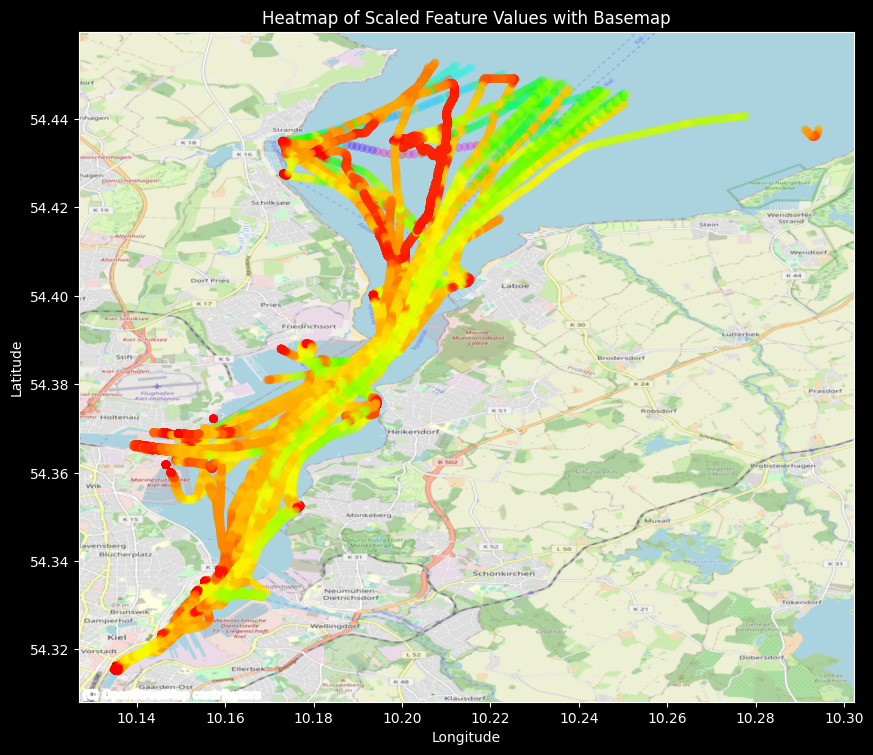

In [32]:

# Convert the TrajectoryCollection to a GeoDataFrame
gdf = concatenated_df

# Define the OSM tile source
tiles_provider = tiles.OSM()

# Create a GeoDataFrame with the geometry representing the trajectories
# This assumes you have a column "geometry" containing LineString geometries in gdf
trajectories_gdf = gdf.groupby('traj_id')['geometry'].apply(lambda x: x.iloc[0]).reset_index()
trajectories_gdf = gpd.GeoDataFrame(trajectories_gdf, geometry='geometry')

# Create a GeoDataFrame with the "scaled_feature" values for each trajectory
feature_gdf = gdf.groupby('traj_id')[scaled_feature_col_name].mean().reset_index()

# Merge the two GeoDataFrames based on the "traj_id"
heatmap_gdf = pd.merge(trajectories_gdf, feature_gdf, on='traj_id')

# Define the colormap
cmap = 'hsv'#'viridis'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap using Geopandas
im = gdf.plot(column=scaled_feature_col_name, cmap=cmap, linewidth=0.1, ax=ax, alpha=0.3, legend=False)


# Add basemap from OpenStreetMap using contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap of Scaled Feature Values with Basemap')

# cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Show the plot
plt.show()
# plt.savefig('tc_heatmap.png', bbox_inches='tight')

+ Create a contour plot

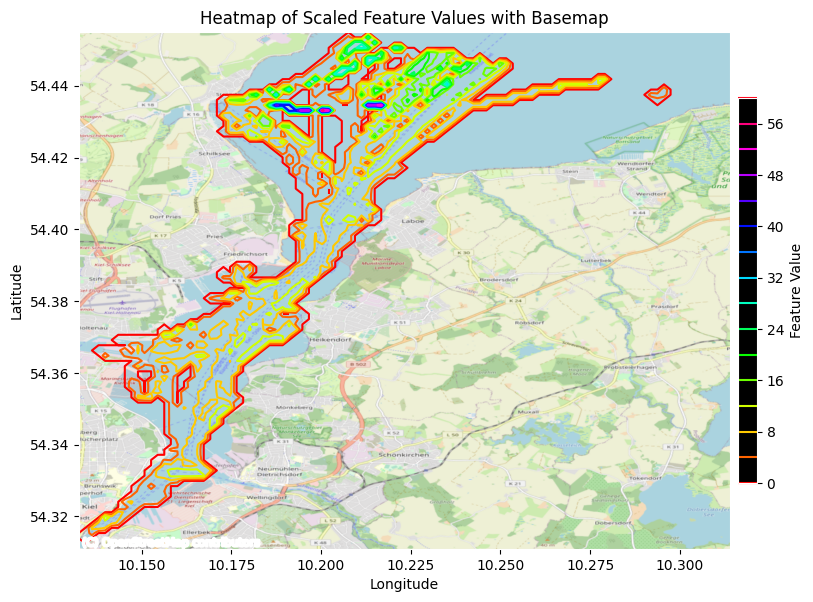

In [33]:
# Define the colormap
cmap = 'hsv'#'viridis'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Set the background color to be transparent
fig.set_facecolor('none')#('none')  # or 'rgba(0,0,0,0)' for full transparency

# Create contour lines on top of the heatmap
x = np.linspace(lon_min, lon_max, num=100)#np.array([point.x for point in gdf.geometry])
y = np.linspace(lat_min, lat_max, num=100)#np.array([point.y for point in gdf.geometry])
# z = gdf[scaled_feature_col_name].values

# Create a meshgrid for contour plotting
xi, yi = np.meshgrid(x, y)
# zi = np.interp(xi, x, z)
# zi = zi.reshape(xi.shape)
zi = grid_feature

# Plot contour lines
contour_lines = plt.contour(xi, yi, zi, levels=15, cmap=cmap)
# Add basemap from OpenStreetMap using contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis labels and title
ax.set_xlabel('Longitude', color='black')
ax.set_ylabel('Latitude', color='black')
ax.set_title('Heatmap of Scaled Feature Values with Basemap', color='black')

# Set colorbar with black text color
cbar = plt.colorbar(contour_lines, ax=ax, label='Feature Value', pad=0.01, shrink=0.5)
# Set colorbar tick label colors to black
cbar.ax.yaxis.set_tick_params(color='black')
# Set colorbar label color to black
cbar.set_label('Feature Value', color='black')
# Get the colorbar tick labels and set their color to black
cbar.ax.yaxis.set_tick_params(color='black')
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_color('black')

# Set tick label colors to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')


# Show the plot
plt.show()
# plt.savefig('tc_heatmap_2.png', bbox_inches='tight')

In [34]:
# Create a HoloViews plot of the clusters
tc_heatmap = tc.to_point_gdf().hvplot(geo=True,
                                        tiles='OSM',
                                        title='Speed calculated Heatmap',
                                        color=scaled_feature_col_name,
                                        colorbar=True,
                                        cmap='hsv',
                                        line_width=2,
                                        alpha=0.6,
                                        frame_width=1200,
                                        frame_height=1200,
                                        legend=True)
hvplot.save(tc_heatmap, 
            'tc_heatmap.html', 
            fmt='html')

In [35]:
tc_heatmap

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (scaled:calc_speed:median)